# Recurrent Neural Networks (RNN)

The term neural network encompasses a wide variety of learning methods, although in a general way it can be said that a neural network is like a nonlinear statistical model defined by means of an arbitrarily large number of parameters.
Its structure is usually represented by a directed graph, i.e., a set of nodes (units or neurons) connected by edges.
Each node $i$ receives a numerical vector, processes it by applying a certain activation function -a nonlinear function- and returns the result to another node $j$ to which it is connected by an edge. Each edge has an associated weight $w_{ij}$, which determines the importance and sign of the connection. The neurons are stacked by the node $j$. Neurons are stacked in layers and in each layer an activation function is usually defined. Three types of layers can be distinguished in a neural network: the input layer receives the input data and consists of as many neurons as are necessary to train the proposed architecture; the output layer provides the result or predictions defined according to the problem; a series of hidden layers is placed between the two previous layers and combines the inputs with a set of weights and returns them after applying a given activation function, i.e., provides nonlinear transformations of the data in a chained fashion.

The training of a network consists of adjusting the parameters that define it by updating them at each step so that they approach the reference values (input data associated with the output data) provided. For this purpose, the data of the training set are provided to the network and a training set is generated. It is then compared with the actual observations and the parameters are adjusted so that the network output is closer to the actual data. the network output is closer to the real data, for which the back propagation algorithm is used.
In this way, a neural network is capable of constructing complex relationships from the information contained in the data. from the information contained in the data provided.

As a general rule, neural networks converge after a certain training time to a sufficiently accurate model, although there are certain hyperparameters that can be adjusted to obtain the most optimal model possible. In this implementation, the following have been considered The following have been considered in this implementation: window size, number of neurons per layer, number of layers, dropout rate, type of neuron and activation function.

There is, therefore, a large number of hyperparameters with which to construct a neural network, defining a large number of possible combinations of these (configurations). Consequently, obtaining an optimal configuration is a rather computationally expensive problem. Some methods to obtain optimal configurations are brute force search, random search, bayesian optimization, hyperband and BOHB (Bayesian optimization and hyperband). Random search is used here for simplicity and because of the nature of the problem (the absence of sufficient data suggests that networks are not a good starting option).


# Setup

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import itertools
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from utils import *
import json, os
import datetime

# filter warnings
import warnings
warnings.filterwarnings("ignore")


seed=123

# Grid search

**Split dataset into 1-dimensional subsets**

The first step of this analysis is the division of the univariate series into three subsets. These subsets are: training data set (55%), validation data set (15%) and test data set (30%). 

The former is used to fit the parameter values and the latter to assess the generalization and predictive ability of the model; the validation set is now used to tune the hyperparameters of the network. At this point it is possible to note certain difficulties that any neural network will have with these data: the original series is insufficiently complex and extensive. In addition to this, there is the need to reserve the validation and test datasets, reducing to 55% the data set from which the network must learn from.

**Scale** 

In order for the network to capture the information correctly, the data must be normalized. This also reduces computation time. To do this, the maximum ($max_{train}$) and minimum ($min_{train}$) values of train subset are taken and the following scaling formula is applied to each value of each subset:

$$(x - min_{train}) / (max_{train} - min_{train})$$

where $x$ can be any observation of any subset (train, validation or test). 

The goal is to place all observations on the scale [0, 1].


**Make dataset 2-dimensional**

The infected series is a univariate series, that is, a one-dimensional vector. The task of the neural network is to find the relationship of a series of input values $X$ with output values $Y$: $f(X)=Y$. It is therefore necessary to transform the available univariate series into input vectors $X$ related to output vectors $Y$ that maintain the temporal sense. In this sense, $X$ is the set of $window\_size$ past observed values and $Y$ is the set of $steps\_ahead$ values to be predicted. The two dimensions of $X$ are characterized by the number of predictors (defined by $window\_size$) and the number of observed time windows; the two dimensions of $Y$ are characterized by the number of $steps\_ahead$ and the number of observed time windows. 

To define some types of networks as RNN, three dimensions are required, not two: every input to RNN layer must be three-dimensional, where the dimensions are as follows: [batch, window_size, features]. In this case the series is one-dimensional so that features will always be 1.


**Grid Search**

Once the data is prepared, a mesh with hyperparameters is defined. This mesh is excessively large, so a random sample of $max\_configs$ combinations is taken. With each combination, a model is created and evaluated.


**Final notes**

Due to the low complexity of the treated series (it has few observations and is univariate), the series could tend to overfit and simply reproduce the previous data. For this reason, quite aggressive dropouts have been defined in the mesh. 

# Modeling

Define the path to store the results of the grid search.

In [204]:
base_dir = Path(os.getcwd()).parents[0]

path_to_store_results = os.path.join(base_dir, 'data', 'nn-results', 'evaluations')
path_to_save_models = os.path.join(base_dir, 'data', 'nn-results', 'models')

## Data
Data on 14-day cumulative incidence per 100000 population in Spain are used.

In [205]:
# read processed data
path = 'cumulative-incidence-14-days.csv'
df = load_last_final_data(file_name=path)
df.head()

c:\Users\Bisite\Desktop\COVID-Dynamics-Model-Comparison\data\final-data\cumulative-incidence-14-days.csv


,Infected
Date,
2020-02-21,0.010685
2020-02-22,0.012821
2020-02-23,0.014958
2020-02-24,0.019232
2020-02-25,0.021369


Define the class to perform the parameter search (first, the rmsle is defined as the tensorflow metric.).

In [206]:
class rmsle(tf.keras.metrics.Metric):
    def __init__(self , name='rmsle', **kwargs):
        super(rmsle, self).__init__(name=name, **kwargs)
        self.error_array = None


    def update_state(self, y_true, y_pred, sample_weight=None):

        y_true = tf.math.log(y_true)
        y_pred = tf.math.log(y_pred)

        error = y_pred-y_true

        error = tf.math.square(error)

        if self.error_array is not None:
            self.error_array = tf.concat([self.error_array,error],axis=0)
        else:
            self.error_array = error


        self.error_array = error

    def reset_state(self):
        self.error_array = None
    

    def result(self):
        total_error = self.error_array
        total_error = tf.math.reduce_mean(total_error)
        total_error = tf.math.sqrt(total_error)
        self.reset_states()
        return total_error


mirmsle = rmsle()

In [207]:
class paramsearch:
    """
    Grid search to get the best parameters

    Args:
        data (pd.DataFrame): univariate series with the data
        steps_ahead (int): number of steps ahead to forecast
        hyperparams (dict of lists): dict of hyperparams 
        split_sizes (tuple): sizes of train and validation sets. By default=(0.55,0.15).
                             (test size is 1-(0.55+0.15)=0.3 for default case)
        max_configs (int): max number of combinations to evaluate
        metrics (dict): metrics used in evaluation
    """

    def __init__(self, data, steps_ahead=14, max_configs=100, split_sizes=(0.55, 0.15), hyperparams=None, metrics=metrics):

        # store data
        self.data = data
        self.train_df = None
        self.val_df = None
        self.test_df = None

        # if no grid specified, define grid
        if hyperparams is None:
            self.hyperparams = {
                'window_size': [i for i in range(10, 25)],
                'num_neurons': [i for i in range(5, 20)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.5, 0.6, 0.7, 0.8],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
        else:
            self.hyperparams = hyperparams

        # store attributes
        self.steps_ahead = steps_ahead
        self.max_configs = max_configs
        self.train_size = split_sizes[0]
        self.val_size = split_sizes[1]
        self.metrics = metrics
        self.tf_metrics = metrics = [
            # RMSLETF,
            mirmsle,
                                    'mae', 
                                    tf.keras.metrics.RootMeanSquaredError(), 
                                    tf.keras.metrics.MeanAbsolutePercentageError()
                                    ]

        # train config
        self.epochs = 100
        self.batch_size = 16

        # vars to store experiment results
        self.history_log = {}
        self.model_log = {}
        self.pandas_log = None
        self.all_data_from_model = {}

    def run_experiment(self, verbose=1):
        # set seed
        np.random.seed(seed)

        # generate grid
        hypergrid = list(self.generate_hypergrid())
        # subsample hypergrid (get only some combinations of hyperparameters)
        hypergrid = self.subsample_hypergrid(hypergrid)

        # 1. univariate train-val-test split
        self.train_df, self.val_df, self.test_df = self.univariate_train_test_split(
            self.data)

        # 2. scale each train-val-test split
        train_df_sc = self.scale_data(self.train_df)
        val_df_sc = self.scale_data(self.val_df)
        test_df_sc = self.scale_data(self.test_df)

        # 3. loop over hypergrid
        for hypercomb in hypergrid:
            try:
                if verbose:
                    print(hypercomb)

                # 3.1. make dataset
                X_train, Y_train = self.make_dataset(
                    window_size=hypercomb['window_size'], series=train_df_sc)
                X_val, Y_val = self.make_dataset(
                    window_size=hypercomb['window_size'], series=val_df_sc)
                X_test, Y_test = self.make_dataset(
                    window_size=hypercomb['window_size'], series=test_df_sc)

                # 3.2. build model
                model = self.build_model(hypercomb['num_layers'],
                                        hypercomb['num_neurons'],
                                        hypercomb['dropouts'],
                                        hypercomb['window_size'],
                                        hypercomb['layer_type'],
                                        hypercomb['activation_function'],
                                        self.tf_metrics)

                # 3.3. train model
                history = model.fit(X_train, Y_train, validation_data=(
                    X_val, Y_val), batch_size=self.batch_size, epochs=self.epochs,
                    verbose=0)

                # 3.4. store history in history dict
                self.history_log['_'.join(
                    [str(param) for param in hypercomb.values()])] = history

                # 3.5. store trained model in model dict
                self.model_log['_'.join([str(param)
                                        for param in hypercomb.values()])] = model

                # 3.6. evaluate model on validation set and store results
                result_val = self.evaluate_model(model, X_val, Y_val)
                result_val = {f'val_{k}':v for k,v in result_val.items()}
                # print(result_val)

                # 3.7. evaluate model on test set and store results
                result_test = self.evaluate_model(model, X_test, Y_test)
                result_test = {f'test_{k}':v for k,v in result_test.items()}
                # print(result_test)

                # 3.8. print combination and evaluation results on val and train
                newrow = pd.DataFrame({**hypercomb, **result_val, **result_test})
                # display(newrow)

                # 3.9. store all data from model in dict
                self.store_all_data(hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test)
                # add row to metric table
                if self.pandas_log is None:
                    self.pandas_log = newrow
                else:
                    self.pandas_log = pd.concat([self.pandas_log, newrow])

            except Exception as e:
                print(e)
                continue

    def generate_hypergrid(self):
        """Returns all possible combinations 
            of the hyperparameters"""
        keys = self.hyperparams.keys()
        vals = self.hyperparams.values()
        for instance in itertools.product(*vals):
            yield dict(zip(keys, instance))

    def subsample_hypergrid(self, hypergrid):
        """Returns subsamples of the hypergrid"""
        # get self.max_configs random combinations of hyperparameters combinations
        subsamples = random.sample(range(len(hypergrid)), self.max_configs)
        subsamples = [hypergrid[i] for i in subsamples]
        print(f'Number of configs to evaluate: {len(subsamples)}')
        print('-------------------------------------------------\n')
        return subsamples

    def univariate_train_test_split(self, data):
        """Splits the data into train, val and test sets"""
        # split data into univariate train, val and test sets
        n = len(data)
        train_df = data[:int(n * self.train_size)]
        val_df = data[int(n * self.train_size):int(n * (self.train_size + self.val_size))]
        test_df = data[int(n * (self.train_size + self.val_size)):]
        return train_df, val_df, test_df

    def scale_data(self, data_subset, train_df=None, type='maxmin'):
        """Scales the data into [0,1] """
        if train_df is None:
            train_df = self.train_df
        if type == 'maxmin':
            # if any value in data_subset is less than train_df.min(), replace by train_df.min()
            data_subset = data_subset.where(data_subset > train_df.min(), train_df.min())
            return (data_subset - train_df.min()) / (train_df.max() - train_df.min())
        if type == 'standard':
            return (data_subset - train_df.mean()) / train_df.std()

    def descale_data(self, data_subset, train_df=None, type='maxmin'):
        """Descales the data into original scale"""
        if train_df is None:
            train_df = self.train_df
        if type == 'maxmin':
            return data_subset * (train_df.max() - train_df.min()) + train_df.min()
        if type == 'standard':
            return data_subset * train_df.std() + train_df.mean()

    def make_dataset(self, series, window_size=None, steps_ahead=None, dropna=True):
        """Prepare dataset to have two dimensions for X and y"""

        if window_size is None:
            window_size = self.window_size
        if steps_ahead is None:
            steps_ahead = self.steps_ahead

        # create a dataframe with the data
        series = pd.Series(series.values.ravel(), index=pd.DatetimeIndex(
            series.index), dtype=pd.Int8Dtype)
        # lag features
        X = pd.DataFrame({'t-'+str(i): series.shift(i)
                         for i in range(window_size)})
        # steps ahead targets
        y = pd.DataFrame({'step_'+str(i): series.shift(-i)
                         for i in range(1, steps_ahead+1)})
        # # add the lagged features to the dataframe
        # data = pd.concat({'Features': X.iloc[:,::-1], 'Targets': y}, axis=1)

        # drop nan rows
        if dropna:
            X = X.dropna()
            y = y.dropna()

        # make the index of y and X equal
        y, X = y.align(X, join='inner', axis=0)
        return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')


    def build_layer(self, num_neurons, dropouts, layer_type, activation_function, last=False):
        if not last:
            if layer_type == 'lstm':
                return layers.LSTM(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
        else:
            if layer_type == 'lstm':
                return layers.LSTM(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)

    def build_model(self, num_layers, num_neurons, dropouts, window_size, layer_type, activation_function, metrics=[]):
        model = Sequential()
        model.add(layers.InputLayer(input_shape=(window_size,)))
        model.add(layers.Reshape((window_size, 1)))
        for i in range(num_layers-1):
            model.add(self.build_layer(num_neurons, dropouts,
                      layer_type, activation_function))
        model.add(self.build_layer(num_neurons, dropouts,
                  layer_type, activation_function, last=True))

        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3), 
            # loss='msle', 
            loss='mse', 
            metrics=metrics)

        return model

    def evaluate_model(self, model, X_data_subset=None, Y_data_subset=None):
        """Evaluates the model on (X_data_subset, Y_data_subset) set
            Those subsets are scaled.
        """
        evaluation = {}

        # 1. generate forecasts
        preds = model.predict(X_data_subset)
        
        # 2. descale the forecasts
        descaled_preds = self.descale_data(preds)
        descaled_Y_data_subset = self.descale_data(
            Y_data_subset)
        # descaled_Y_data_subset = np.asarray(Y_data_subset).astype('float32')

        # 3. evaluate the model per each step_ahead
        for i in range(self.steps_ahead):
            nn_step_evaluation = {}
            # 3.1. evaluate the model on the current step_ahead
            data_subset_step = descaled_Y_data_subset[:, i]
            predicted_step = descaled_preds[:, i]
            # 3.2. evaluate the model on the current step_ahead
            for metric_name, metric in self.metrics.items():
                nn_step_evaluation[metric_name] = metric(
                    data_subset_step, predicted_step)

            evaluation[f'step_{i+1}'] = nn_step_evaluation
        return evaluation

    def get_predictions(self, model, window_size=None):
        # 1. univariate train-val-test split
        self.train_df, self.val_df, self.test_df = self.univariate_train_test_split(
            self.data)
            
        # 2. scale each train-val-test split
        train_df_sc = self.scale_data(self.train_df)
        val_df_sc = self.scale_data(self.val_df)
        test_df_sc = self.scale_data(self.test_df)

        # 3. make dataset
        X_train, Y_train = self.make_dataset(
            window_size=window_size, series=train_df_sc)
        X_val, Y_val = self.make_dataset(
            window_size=window_size, series=val_df_sc)
        X_test, Y_test = self.make_dataset(
            window_size=window_size, series=test_df_sc)

        # 4. make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        test_preds = model.predict(X_test)

        # 5. descale the predictions
        train_preds = self.descale_data(train_preds)
        val_preds = self.descale_data(val_preds)
        test_preds = self.descale_data(test_preds)

        # and descale the sets
        Y_train = self.descale_data(Y_train)
        Y_val = self.descale_data(Y_val)
        Y_test = self.descale_data(Y_test)

        # 6. return the predictions
        return Y_train, train_preds, Y_val, val_preds, Y_test, test_preds
    
    def store_all_data(self, hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test):
        results = {}
        key = '_'.join([str(param) for param in hypercomb.values()])
        results['hypercomb'] = hypercomb
        results['X_train'] = self.descale_data(X_train)
        results['Y_train'] = self.descale_data(Y_train)
        results['X_val'] = self.descale_data(X_val)
        results['Y_val'] = self.descale_data(Y_val)
        results['X_test'] = self.descale_data(X_test)
        results['Y_test'] = self.descale_data(Y_test)
        results['train_forecasts'] = self.descale_data(model.predict(X_train))
        results['val_forecasts'] = self.descale_data(model.predict(X_val))
        results['test_forecasts'] = self.descale_data(model.predict(X_test))
        results['result_val'] = result_val
        results['result_test'] = result_test
        self.all_data_from_model[key] = results
        
        # # save dict to disk
        # file_name = os.path.join(path_to_store_results, key)
        # results_df = pd.DataFrame.from_dict(results)
        # results_df.to_csv(file_name + '.csv')

Show univariate split of data into train, validation and test subsets.

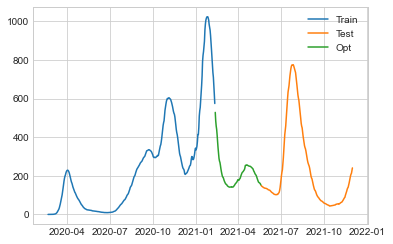

In [208]:
train, val, test = paramsearch(df, split_sizes=(0.55, 0.15)).univariate_train_test_split(data=df)
# plot subsets
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(val, label='Opt')
plt.legend()
plt.show()

In [210]:
# select the variable of interest
serie = df['Infected']

## Random search of best config 

An object of the class is created and the mesh of interest is defined to carry out the random search.

In [211]:
hyperparams = {'window_size': [i for i in range(4, 30)],
                'num_neurons': [i for i in range(5, 30)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.6, 0.7, 0.8],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
                
parasect = paramsearch(serie,max_configs=100, hyperparams=hyperparams)

In [212]:
# run random grid search
parasect.run_experiment()

Number of configs to evaluate: 100
-------------------------------------------------

{'window_size': 6, 'num_neurons': 5, 'num_layers': 3, 'dropouts': 0.8, 'layer_type': 'lstm', 'activation_function': 'relu'}
6/6 [==============================] - 0s 3ms/step
{'window_size': 15, 'num_neurons': 14, 'num_layers': 4, 'dropouts': 0.8, 'layer_type': 'gru', 'activation_function': 'relu'}
6/6 [==============================] - 0s 4ms/step
{'window_size': 25, 'num_neurons': 25, 'num_layers': 1, 'dropouts': 0.6, 'layer_type': 'recurrent', 'activation_function': 'tanh'}
5/5 [==============================] - 0s 0s/step
{'window_size': 29, 'num_neurons': 5, 'num_layers': 2, 'dropouts': 0.7, 'layer_type': 'recurrent', 'activation_function': 'relu'}
5/5 [==============================] - 0s 2ms/step
{'window_size': 26, 'num_neurons': 21, 'num_layers': 2, 'dropouts': 0.8, 'layer_type': 'gru', 'activation_function': 'relu'}
5/5 [==============================] - 0s 3ms/step
{'window_size': 18, 'num_

# Check results

In [128]:
# show nn config and its metrics
parasect.pandas_log

,window_size,num_neurons,num_layers,dropouts,layer_type,activation_function,val_step_1,val_step_2,val_step_3,val_step_4,...,test_step_5,test_step_6,test_step_7,test_step_8,test_step_9,test_step_10,test_step_11,test_step_12,test_step_13,test_step_14
RMSLE,14,19,4,0.6,gru,relu,1.174373,1.190577,1.132849,1.041236,...,0.888094,0.895774,0.891670,0.860307,0.886985,0.911455,0.898698,0.893912,0.878121,0.870577
MAE,14,19,4,0.6,gru,relu,134.619843,135.374100,131.930344,125.875313,...,149.235748,148.877884,148.717834,144.269379,146.502228,145.121582,142.968048,138.866440,137.779083,135.469360
RMSE,14,19,4,0.6,gru,relu,139.077301,139.813004,137.139481,131.388565,...,233.921631,235.622437,238.014069,235.411224,239.314880,239.905350,240.546082,238.318420,238.334579,236.261551
MAPE,14,19,4,0.6,gru,relu,0.686915,0.691182,0.669534,0.636331,...,0.448298,0.441447,0.430225,0.409593,0.412796,0.403388,0.388862,0.373086,0.383300,0.391540
RMSLE,7,9,3,0.7,recurrent,tanh,0.234164,0.233817,0.232865,0.247782,...,0.968072,0.975940,0.976077,0.989780,0.978498,0.985325,0.986665,0.985918,0.988238,0.998760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAPE,28,26,3,0.7,lstm,tanh,0.210687,0.192247,0.192082,0.192869,...,0.483052,0.531346,0.558353,0.608617,0.665539,0.711232,0.763477,0.885113,0.885039,0.960860
RMSLE,28,19,4,0.8,recurrent,tanh,1.130091,0.753806,0.416879,0.238997,...,1.183644,1.672438,1.885607,1.181680,1.033436,1.828088,1.002922,1.116038,0.971915,1.074976
MAE,28,19,4,0.8,recurrent,tanh,394.857941,204.213745,80.251732,36.982826,...,224.881516,401.522491,565.497803,224.663757,196.758850,518.523438,191.067780,210.635986,185.616150,202.021378
RMSE,28,19,4,0.8,recurrent,tanh,396.522827,208.581100,90.948074,45.414238,...,248.359711,446.984619,613.408447,247.790894,239.918213,570.085876,242.363602,239.908066,248.842361,237.674316


In [129]:
# show history from model training
parasect.history_log

{'14_19_4_0.6_gru_relu': <keras.callbacks.History at 0x1b7ef0bdb20>,
 '7_9_3_0.7_recurrent_tanh': <keras.callbacks.History at 0x1b7f083f610>,
 '5_22_3_0.7_lstm_tanh': <keras.callbacks.History at 0x1b8039c2a00>,
 '27_8_4_0.8_gru_tanh': <keras.callbacks.History at 0x1b80fa4a7c0>,
 '11_10_4_0.8_recurrent_relu': <keras.callbacks.History at 0x1b7d85a4610>,
 '6_24_1_0.7_recurrent_relu': <keras.callbacks.History at 0x1b7d5f7cb50>,
 '23_19_1_0.7_lstm_tanh': <keras.callbacks.History at 0x1b7d5aa95e0>,
 '11_22_4_0.6_lstm_relu': <keras.callbacks.History at 0x1b7a06eb6d0>,
 '17_10_2_0.7_gru_tanh': <keras.callbacks.History at 0x1b7e82e4f10>,
 '15_8_1_0.6_gru_relu': <keras.callbacks.History at 0x1b7e9e89dc0>,
 '10_5_3_0.8_lstm_relu': <keras.callbacks.History at 0x1b7e859cac0>,
 '20_19_1_0.7_lstm_tanh': <keras.callbacks.History at 0x1b7de4a34c0>,
 '13_18_4_0.6_recurrent_relu': <keras.callbacks.History at 0x1b7de139f10>,
 '8_10_1_0.7_gru_relu': <keras.callbacks.History at 0x1b7e2eb91c0>,
 '27_20_3_0.6

In [1]:
# for log_key in parasect.history_log:
#     plot_history(log_key, parasect)

In [131]:
# models
parasect.model_log

{'14_19_4_0.6_gru_relu': <keras.engine.sequential.Sequential at 0x1b7e2e1af40>,
 '7_9_3_0.7_recurrent_tanh': <keras.engine.sequential.Sequential at 0x1b7f08249a0>,
 '5_22_3_0.7_lstm_tanh': <keras.engine.sequential.Sequential at 0x1b7efd3afa0>,
 '27_8_4_0.8_gru_tanh': <keras.engine.sequential.Sequential at 0x1b803878d00>,
 '11_10_4_0.8_recurrent_relu': <keras.engine.sequential.Sequential at 0x1b80f8bfa60>,
 '6_24_1_0.7_recurrent_relu': <keras.engine.sequential.Sequential at 0x1b7d8766e80>,
 '23_19_1_0.7_lstm_tanh': <keras.engine.sequential.Sequential at 0x1b7e2daa0d0>,
 '11_22_4_0.6_lstm_relu': <keras.engine.sequential.Sequential at 0x1b7ded1c8b0>,
 '17_10_2_0.7_gru_tanh': <keras.engine.sequential.Sequential at 0x1b7e86514c0>,
 '15_8_1_0.6_gru_relu': <keras.engine.sequential.Sequential at 0x1b7f20e7070>,
 '10_5_3_0.8_lstm_relu': <keras.engine.sequential.Sequential at 0x1b7f1f7a8e0>,
 '20_19_1_0.7_lstm_tanh': <keras.engine.sequential.Sequential at 0x1b7f1c97100>,
 '13_18_4_0.6_recurrent_

In [132]:
model_keys = list(parasect.all_data_from_model.keys())

# model_results = parasect.all_data_from_model['13_4_0.5_13_gru_relu']
# test_forecasts = model_results['test_forecasts']
# test = model_results['Y_test']

# fig = plt.figure(figsize=(12, 5))
# plt.plot(test[:,-1], label='real')
# plt.plot(test_forecasts[:, -1], label='predicted')


# Get best model 

The model that provides the best results for the time horizon 14 is now selected. The most reliable metric in this case due to the characteristics of the series is the RMSLE, although the MAE and RMSE support its results.

In [133]:
compare_evals = {}
for model_name in model_keys:
    model_results = parasect.all_data_from_model[model_name]
    eval_on_step_14 = model_results['result_test']['test_step_14']
    compare_evals[model_name] = eval_on_step_14

In [134]:
best_models = pd.DataFrame(compare_evals).T.sort_values(by='RMSLE').head()
best_models.style.highlight_min(axis=0)

,RMSLE,MAE,RMSE,MAPE
8_28_4_0.6_lstm_tanh,0.630117,118.501816,172.712433,0.566819
9_14_2_0.6_lstm_tanh,0.724422,145.740921,190.072220,0.844211
10_16_3_0.6_gru_relu,0.735781,119.456009,209.974716,0.405238
13_19_3_0.6_gru_tanh,0.735886,131.953293,198.213409,0.707387
12_5_3_0.6_lstm_relu,0.741770,132.705734,191.086334,0.807656


In [146]:
# print(best_models.round(2).to_latex())

In [136]:
best_model = best_models.iloc[0].name
# save best model to disk
trained_model = parasect.model_log[best_model]
trained_model.save(os.path.join(path_to_save_models, 'trained_model.h5'))
best_model

'8_28_4_0.6_lstm_tanh'

Then the best model obtained uses a window size 8 (8 points passed to predict the next 14), 28 neurons per layer, 4 layers, a dropout rate of 0.6, lstm type cells and tanh activation function.

# Forecasts exploration 

The predictions of the train and test subsets are now obtained to explore their behavior.

In [140]:
best_ws = int(best_model.split('_')[0])
Y_train, train_preds, Y_val, val_preds, Y_test, test_preds = parasect.get_predictions(trained_model, window_size=best_ws)

6/6 [==============================] - 0s 4ms/step


In [260]:
y_fit_train = pd.DataFrame(train_preds, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[8:len(y_fit_train)+8])
y_fit_test = pd.DataFrame(test_preds, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[-len(y_fit_test):])
y_train = pd.DataFrame(Y_train, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[8:len(y_fit_train)+8])
y_test = pd.DataFrame(Y_test, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[-len(y_fit_test):])

baseline_values = np.array([np.repeat(i, 14) for i in np.concatenate((Y_val[-1, -1].reshape(1), Y_test[:, 0][:-1]))])
y_baseline_test = pd.DataFrame(baseline_values, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[-len(y_fit_test):])


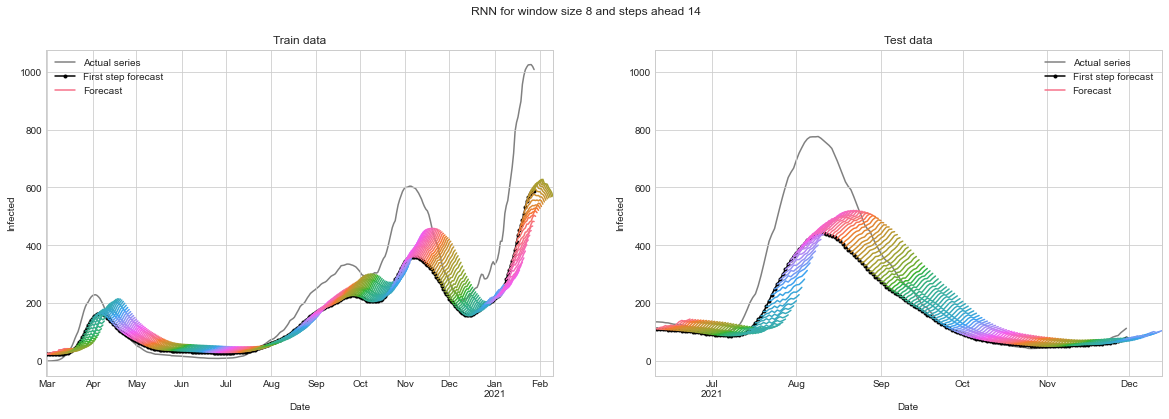

In [143]:
palette = dict(palette='husl', n_colors=64)
# fig, ax1 = plt.subplots(1, 1, figsize=(11, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# train data
ax1 = y_train['y_step_1'].plot(color='grey', zorder=0, ax=ax1)
y_fit_train['y_step_1'].plot(ax=ax1, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit_train, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Actual series', 'First step forecast', 'Forecast'])

# test data
ax2 = y_test['y_step_1'].plot(color='grey', zorder=0, ax=ax2)
y_fit_test['y_step_1'].plot(ax=ax2, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit_test, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Actual series', 'First step forecast', 'Forecast'])

# set title
ax1.set_title('Train data')
ax2.set_title('Test data')
fig.suptitle(f'RNN for window size {best_ws} and steps ahead 14')

# label axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Infected')
ax2.set_xlabel('Date')
ax2.set_ylabel('Infected')

# set same y scale for both axes
ax2.set_ylim(ax1.get_ylim())

plt.show()

The predictions show how the model is practically unable to capture the dynamics of the series. It seems that the model is overfitted, as it repeats the patterns of the series but shifted in time. This is indicative of the model's inability to extract useful information from the data and instead memorizes it and reproduces its past behavior. In addition, most predictions are underestimated. On the other hand, all sets of predictions present a particular shape with numerical artifacts. This could also be a consequence of overfitting. All in all, the graphical exploration of the predictions already suggests that this model is deficient. In general, it could be said that recurrent neural networks do not seem to be suitable for predicting the evolution of the cumulative incidence of COVID-19, as the optimal neural network has clear shortcomings.

Below are cleaner graphs comparing the predictions for horizons 1, 7 and 14.

In [265]:
def compare_forecasts_at_step(y_fit, baseline, lower_ci=None, upper_ci=None, test_series=None, step=1):
    """ Compare the forecasts at a given step """

    forecasts_step = y_fit[f'y_step_{step}'].values
    base = baseline[f'y_step_{step}'].values
    fig = plt.figure(figsize=(12, 5))

    plt.plot(test_series[step-1:len(y_fit)+step-1], marker='.', label='Actual series')
    plt.plot(forecasts_step, marker='.', label=f'Forecast step {step}')
    plt.plot(base, '-.', label='Baseline')

    # if prediction intervals are available, plot them
    try:
        lower_ci_step = lower_ci[f'ci_lower_step_{step}'].values
        upper_ci_step = upper_ci[f'ci_upper_step_{step}'].values
        plt.fill_between(range(len(forecasts_step)), lower_ci_step, upper_ci_step, color='lightgrey', alpha=0.5)
    except:
        pass

    plt.title(f'Comparison of forecasts at step {step}')
    plt.legend()
    plt.show()


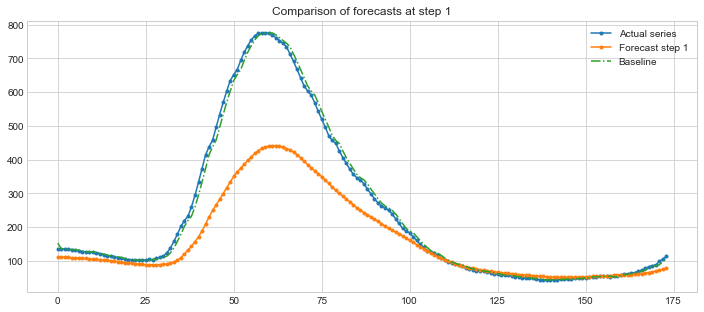

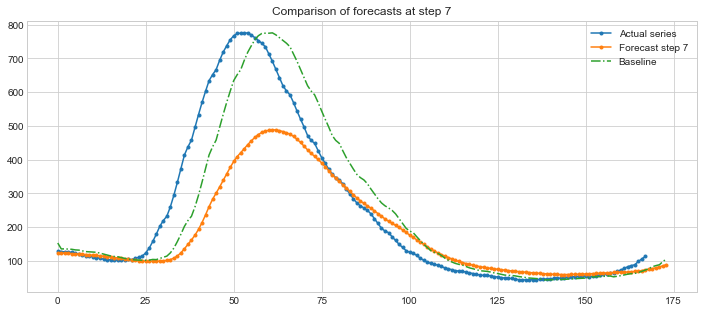

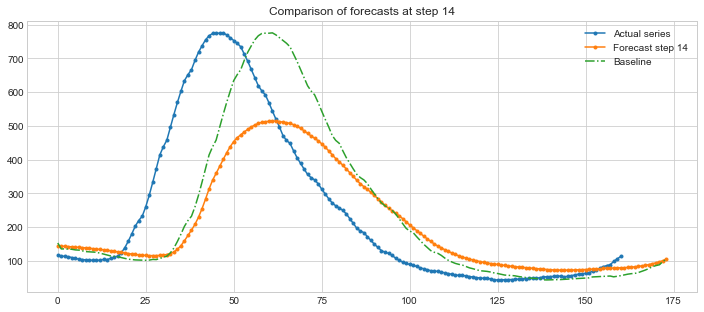

In [266]:
for step in [1, 7, 14]:
    compare_forecasts_at_step(y_fit_test, baseline=y_baseline_test, test_series=Y_test[:,0], step=step)

# Evaluate

Although it can be concluded from the above that the model can be discarded, it is numerically evaluated to support it. 

A dictionary with the best configuration, described by the model name, is defined:

In [156]:
best_config = best_model.split('_')

In [171]:
config = dict(zip(parasect.pandas_log.columns[:6], best_config))
config

{'window_size': '8',
 'num_neurons': '28',
 'num_layers': '4',
 'dropouts': '0.6',
 'layer_type': 'lstm',
 'activation_function': 'tanh'}

Perform evaluation on test set:

In [245]:
# evaluate baseline
baseline_eval = {}
for i in range(parasect.steps_ahead):
    nn_step_evaluation = {}
    # evaluate the model on the current step_ahead
    data_subset_step = y_test.values[:, i]
    predicted_step = y_baseline_test.values[:,i]
    # evaluate the model on the current step_ahead
    for metric_name, metric in parasect.metrics.items():
        nn_step_evaluation[metric_name] = metric(
            data_subset_step, predicted_step)

    baseline_eval[f'baseline_step_{i+1}'] = nn_step_evaluation

In [201]:
# get the log in pandas_log such as the first six columns are the config
str_results = parasect.pandas_log.copy().astype(str)
eval_results = str_results.loc[(str_results['window_size'] == config['window_size']) & (str_results['num_neurons'] == config['num_neurons'])
                & (str_results['num_layers'] == config['num_layers']) & (str_results['dropouts'] == config['dropouts'])
                & (str_results['layer_type'] == config['layer_type']) & (str_results['activation_function'] == config['activation_function'])]
eval_test = eval_results.iloc[:, -14:]
eval_test

,test_step_1,test_step_2,test_step_3,test_step_4,test_step_5,test_step_6,test_step_7,test_step_8,test_step_9,test_step_10,test_step_11,test_step_12,test_step_13,test_step_14
RMSLE,0.32184863,0.33120656,0.33582023,0.35057843,0.36529347,0.39651582,0.41798714,0.44713137,0.47494516,0.5066246,0.5380478,0.56673354,0.6001335,0.6301165
MAE,77.865364,76.94249,75.11663,74.28618,73.47326,75.01746,77.51628,79.29787,85.521095,93.069885,99.78907,104.5348,111.85172,118.501816
RMSE,132.83238,130.94888,130.32759,130.3224,129.89322,134.0165,136.96262,140.50978,145.46416,148.8404,154.59503,160.45767,166.50005,172.71243
MAPE,0.20931138,0.21530211,0.21989757,0.2250332,0.24216434,0.25390083,0.2808742,0.28316483,0.32962885,0.4062095,0.45193574,0.46643347,0.5200026,0.5668188


Add baseline evaluation for further comparison:

In [272]:
evaluation = eval_test.join(pd.DataFrame(baseline_eval))
order_of_cols = [[f'test_step_{i}', f'baseline_step_{i}'] for i in range(1,15)]
order_of_cols = [e for sublist in order_of_cols for e in sublist]
evaluation = evaluation[order_of_cols].astype(float)

# save evaluation of best model found
rnn_evaluation = evaluation.T[::2].T.round(2)
rnn_evaluation = rnn_evaluation.rename(columns={f'test_step_{i}':f'step_{i}' for i in range(1,15)})
path_to_save_results = Path('..\data\model-evaluation-results')
rnn_evaluation.to_csv(os.path.join(path_to_save_results, 'best-rnn-evaluation'))

evaluation

,test_step_1,baseline_step_1,test_step_2,baseline_step_2,test_step_3,baseline_step_3,test_step_4,baseline_step_4,test_step_5,baseline_step_5,...,test_step_10,baseline_step_10,test_step_11,baseline_step_11,test_step_12,baseline_step_12,test_step_13,baseline_step_13,test_step_14,baseline_step_14
RMSLE,0.321849,0.046463,0.331207,0.090045,0.335820,0.133359,0.350578,0.176254,0.365293,0.218751,...,0.506625,0.431315,0.538048,0.472890,0.566734,0.513743,0.600133,0.554123,0.630116,0.594182
MAE,77.865364,8.814128,76.942490,17.512861,75.116630,26.261272,74.286180,35.020443,73.473260,43.755543,...,93.069885,87.318687,99.789070,95.938148,104.534800,104.517220,111.851720,112.958054,118.501816,121.384262
RMSE,132.832380,13.322001,130.948880,26.253437,130.327590,38.987598,130.322400,51.587292,129.893220,64.063599,...,148.840400,125.106857,154.595030,136.800644,160.457670,148.237747,166.500050,159.443268,172.712430,170.433975
MAPE,0.209311,0.036434,0.215302,0.071383,0.219898,0.106261,0.225033,0.141006,0.242164,0.175889,...,0.406210,0.353529,0.451936,0.389906,0.466433,0.426521,0.520003,0.463501,0.566819,0.500935


Represent the metrics evolution through time horizon:

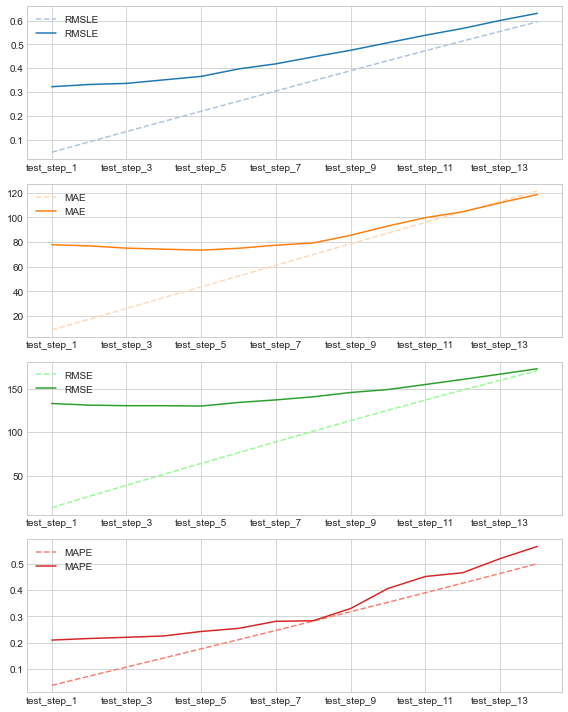

In [258]:
plot_evaluation_evolution_through_steps(evaluation)

The values of the metrics obtained for h = 1 (and horizons up to 7) are too large, since at near horizons the uncertainty is assumed to be smaller and the error should be around zero. The error increases with increasing horizon. At h = 14, it is indicated that the neural network commits an average error rate of 57 %, which is undesirable. The trivial model manages to overcome this evaluation, suggesting that this model is inefficient.
On the other hand, it is necessary to mention that this was to be expected: the quantity, quality and complexity of the original data was insufficient for this type of model to provide adequate performance. Consequently, a computationally expensive process is incurred that does not provide acceptable results.

In [259]:
# print(eval_test.astype(float).round(2).to_latex(header=[f'h={i}' for i in range(1,15)]))

## Residuals exploration

The residuals for time horizon 14 are now explored to discover limitations or possible avenues for refinement.

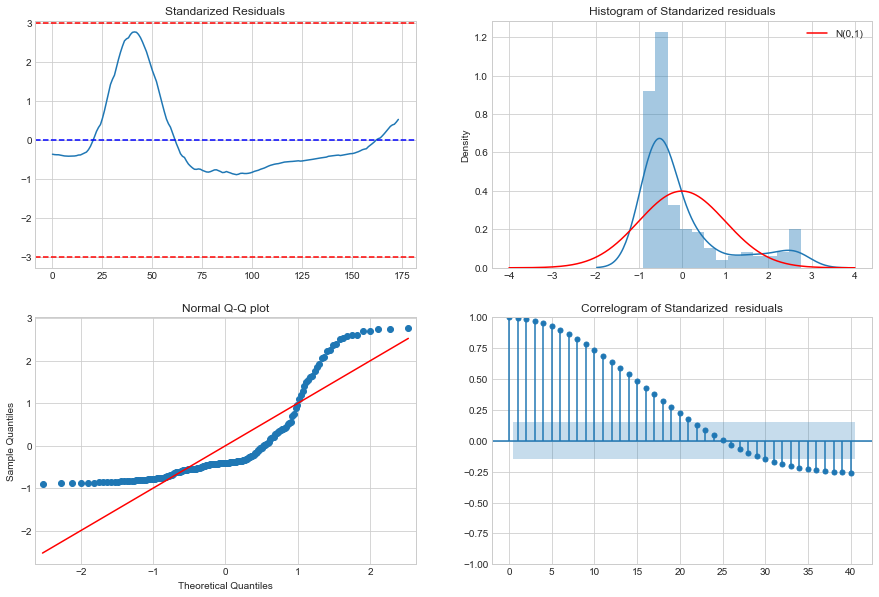

In [22]:
residuals = Y_test[:,-1] - test_preds[:, -1]
diagnostic_checking_residuals(residuals, True)

In [23]:
# characterize the residuals
residuals_stats(standarize_residuals(residuals))

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
0,174.0,0.0,1.002886,-0.898627,-0.625637,-0.399993,0.21505,2.763673,1.294839,1.567535


It can be seen from the line graph that the model underestimates predictions farther from zero and that the shape of the residual series does not resemble that of the white noise process, which would be ideal.
Values greater than 2 appear that could be considered outliers and the Q-Q plot confirms this. They are represented below, where it can be seen that most of them are grouped to the left of the maximum because the series of predictions at maximum because the 14-day prediction series was shifted in time with respect to the observed values (overfitting). The histogram shows a distribution cut off at -1 (the standardized residuals do not take values less than -1) and which clearly differs from the normal one.
Finally, the correlogram confirms that the series of residuals is not white noise and that it is strongly positively correlated.


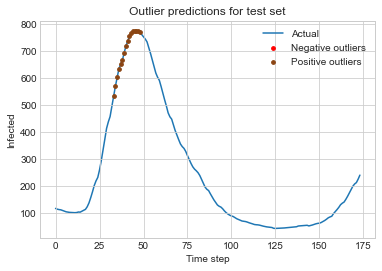

In [24]:
# predicted outliers in the test_ma set
standarized_residuals_test = standarize_residuals(residuals)
outliers_low, = np.where(standarized_residuals_test < -2)
outliers_high, = np.where(standarized_residuals_test > 2)

test = Y_test[:, -1]
plt.plot(test, label='Actual', zorder=0)
plt.scatter(outliers_low, test[outliers_low], color='r', s=14, label='Negative outliers')
plt.scatter(outliers_high, test[outliers_high], color='saddlebrown', s=14, label='Positive outliers')

plt.legend()
plt.title('Outlier predictions for test set')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.show()

# Conclusions

The requirements and recommendations initially set to ensure a good result with this type of model are not met in this case. The form of the data is not sufficiently complex: it is a univariate series defined by 649 observations in total, of which 356 were used to train each neural network (98 to validate the model and 195 for testing purposes). The flexibility they offer then becomes a disadvantage, as it is necessary to adjust a large number of parameters and hyperparameters from a reduced data set. This inevitably results in overfitted models that return poor quality predictions, despite the application of aggressive dropouts. The search for hyperparameters also compromises the efficiency of the method, which can become unfeasible for a relatively large number of maximum configurations to be evaluated or a dense mesh. The neural network considered optimal is very imprecise at the horizons of interest:
RMSLE = 0.42 and MAPE = 0.28 and for h = 7, and RMSLE = 0.63 and MAPE = 0.57 for
h = 14. 
Indeed, for h = 1 the evaluation is worse than that obtained for h = 7
in other models (RMSLE = 0.32 and MAPE = 0.21), which invites us to discard this fitting technique for this particular problem. In addition to imprecision and inefficiency, the model lacks transparency.